In [ ]:
%load_ext autoreload

In [ ]:
%autoreload 2

In [ ]:
%cd ..

In [ ]:
import torch
import torch.distributions as dist
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from rec.utils import kl_estimate_with_mc, plot_running_sum_1d, plot_1d_distribution, kl_estimate_with_mc
from tqdm.notebook import trange
#import seaborn as sns; sns.set(); sns.set_style('whitegrid')
import math
%matplotlib inline
%config InlineBackend.figure_format='retina'

torch.set_default_tensor_type(torch.DoubleTensor)

The KL between q and p is 11.878 nats.


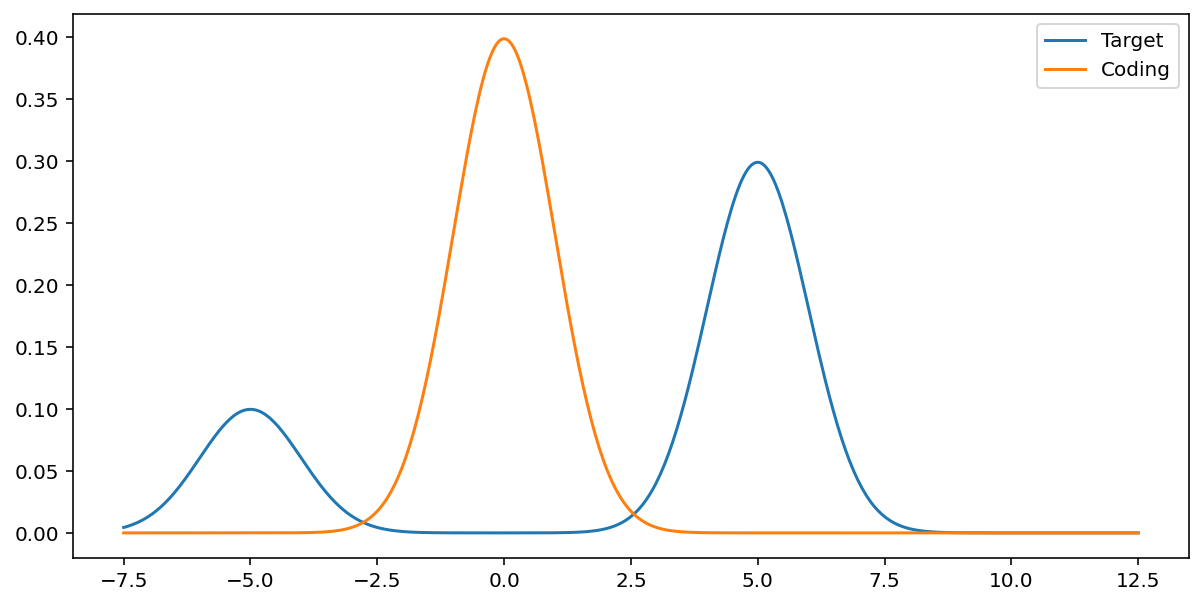

In [158]:
torch.manual_seed(100)

q_var = 1.

p_loc = 0.
p_var = 1.

comp_q = dist.MultivariateNormal(loc=torch.tensor([[-5.], [5.]]), covariance_matrix=q_var*torch.eye(1))
mix_q = dist.categorical.Categorical(probs=torch.tensor([0.25, 0.75]))
q = dist.MixtureSameFamily(mix_q, comp_q)
p = dist.normal.Normal(loc=p_loc, scale = math.pow(p_var, 0.5))
q_loc = q.mean.squeeze()
z_sample = q.sample()

try:
    total_kl = dist.kl_divergence(q, p)
except:
    total_kl = kl_estimate_with_mc(q, p, num_samples=10000).mean()
print(f"The KL between q and p is {total_kl:.3f} nats.")

# ==============================
# PLOT DISTRIBUTIONS
# ==============================

xs = torch.linspace(-7.5, q_loc + 10, 500).reshape(-1, 1)

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(xs, torch.exp(q.log_prob(xs)), label='Target')
ax.plot(xs, torch.exp(p.log_prob(xs)), label='Coding')


ax.legend()

plt.show()

In [159]:
from rec.beamsearch.Coders.Encoder import Encoder
from rec.beamsearch.distributions.CodingSampler import CodingSampler
from rec.beamsearch.distributions.EmpiricalMixturePosterior import EmpiricalMixturePosterior
from rec.beamsearch.samplers.GreedySampling import GreedySampler

In [160]:
samples = q.sample((500,))
z_sample = samples.mean().reshape(-1, 1)

In [161]:
from rec.OptimisingVars.FinalJointOptimiser import FinalJointOptimiser
coding_sampler = CodingSampler
auxiliary_posterior = EmpiricalMixturePosterior
selection_sampler = GreedySampler
omega = 5
initial_seed = 0
beamwidth = 1
epsilon = 0.
alpha = 1./p_var
dummy_encoder = Encoder(q,
                         initial_seed,
                         coding_sampler,
                         selection_sampler,
                         auxiliary_posterior,
                         omega,
                         n_samples_from_target=500,
                         beamwidth=beamwidth,
                         epsilon=epsilon,
                         prior_var=1./alpha)

omega = 5
n_trajectories = 1000
n_auxiliaries = dummy_encoder.n_auxiliary
prior_var = 1./alpha
emp_opt = FinalJointOptimiser(z_sample, omega, n_auxiliaries, total_kl, n_trajectories, prior_var, lr=5e-2)
aux_vars = emp_opt.run_optimiser(epochs=1500)

The mean loss is 2.44876. The mean KL is: 5.54098: 100%|██████████| 1500/1500 [00:07<00:00, 207.18it/s]


In [162]:
num_compressed_samples = 1000
greedy_samples = []
omega = 5
initial_seed = 0
beamwidth = 1
epsilon = 0.
alpha = 1./p_var
for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    enc = Encoder(q,
                 initial_seed,
                 coding_sampler,
                 selection_sampler,
                 auxiliary_posterior,
                 omega,
                 n_samples_from_target=500,
                 beamwidth=beamwidth,
                 epsilon=epsilon,
                 prior_var=1./alpha)
    
    
    #enc.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    z, idx = enc.run_encoder()
    greedy_samples.append(z[0])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [163]:
num_compressed_samples = 1000
bw_5_samples = []
omega = 5
initial_seed = 0
beamwidth = 5
epsilon = 0.
alpha = 1./p_var
for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    enc = Encoder(q,
                 initial_seed,
                 coding_sampler,
                 selection_sampler,
                 auxiliary_posterior,
                 omega,
                 n_samples_from_target=500,
                 beamwidth=beamwidth,
                 epsilon=epsilon,
                 prior_var=1./alpha)
    
    #enc.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    z, idx = enc.run_encoder()
    bw_5_samples.append(z[0])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [164]:
num_compressed_samples = 1000
bw_20_samples = []
omega = 5
initial_seed = 0
beamwidth = 20
epsilon = 0.
alpha = 1./p_var
for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    enc = Encoder(q,
                 initial_seed,
                 coding_sampler,
                 selection_sampler,
                 auxiliary_posterior,
                 omega,
                 n_samples_from_target=500,
                 beamwidth=beamwidth,
                 epsilon=epsilon,
                 prior_var=1./alpha)
    
    #enc.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    z, idx = enc.run_encoder()
    bw_20_samples.append(z[0])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [165]:
num_compressed_samples = 1000
bw_50_samples = []
omega = 5
initial_seed = 0
beamwidth = 50
epsilon = 0.
alpha = 1./p_var
for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    enc = Encoder(q,
                 initial_seed,
                 coding_sampler,
                 selection_sampler,
                 auxiliary_posterior,
                 omega,
                 n_samples_from_target=500,
                 beamwidth=beamwidth,
                 epsilon=epsilon,
                 prior_var=1./alpha)
    
    #enc.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    z, idx = enc.run_encoder()
    bw_50_samples.append(z[0])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [166]:
# estimate KLs

kl_greedy = (q.log_prob(torch.tensor(greedy_samples).reshape(-1, 1)) - p.log_prob(torch.tensor(greedy_samples).reshape(-1, 1))).mean()
kl_5 = (q.log_prob(torch.tensor(bw_5_samples).reshape(-1, 1)) - p.log_prob(torch.tensor(bw_5_samples).reshape(-1, 1))).mean()
kl_20 = (q.log_prob(torch.tensor(bw_20_samples).reshape(-1, 1)) - p.log_prob(torch.tensor(bw_20_samples).reshape(-1, 1))).mean()
kl_50 = (q.log_prob(torch.tensor(bw_50_samples).reshape(-1, 1)) - p.log_prob(torch.tensor(bw_50_samples).reshape(-1, 1))).mean()

In [167]:
q_greedy = q.log_prob(torch.tensor(greedy_samples).reshape(-1, 1)).mean()
q_5 = q.log_prob(torch.tensor(bw_5_samples).reshape(-1, 1)).mean()
q_20 = q.log_prob(torch.tensor(bw_20_samples).reshape(-1, 1)).mean()
q_50 = q.log_prob(torch.tensor(bw_50_samples).reshape(-1, 1)).mean()

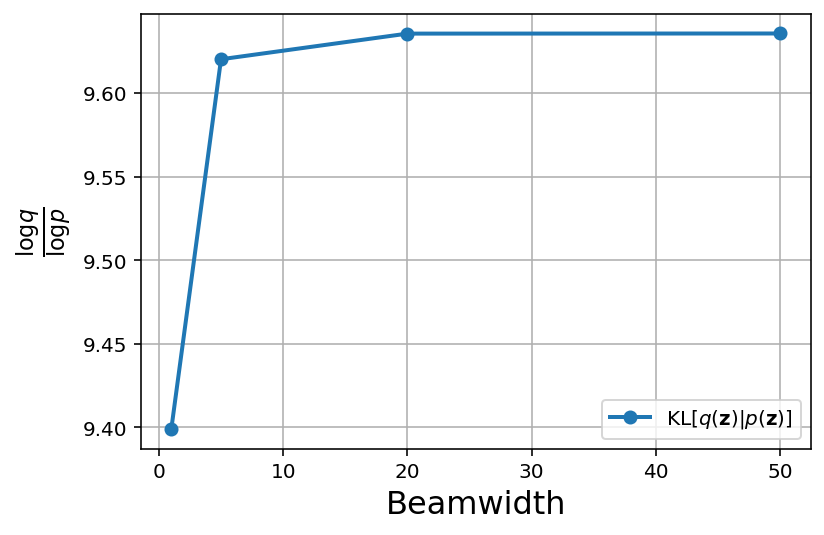

In [168]:
kls = [kl_greedy, kl_5, kl_20, kl_50]
bws = [1, 5, 20, 50]
fs = 16
#plt.axhline(total_kl, color='red', linewidth=2)
plt.plot(bws, kls, 'o-', linewidth=2)
plt.xlabel('Beamwidth', fontsize = fs)
plt.ylabel(r'$\frac{\log q}{\log p}$', fontsize = fs)
plt.grid()
plt.legend([r'$\mathrm{KL}[q(\mathbf{z})\|p(\mathbf{z})]$'])

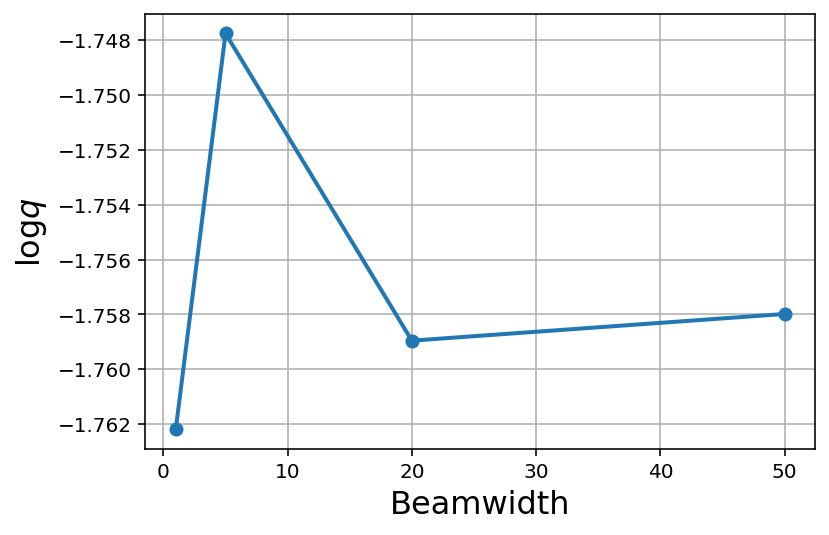

In [169]:
qs = [q_greedy, q_5, q_20, q_50]
bws = [1, 5, 20, 50]
fs = 16
plt.plot(bws, qs, 'o-', linewidth=2)
plt.xlabel('Beamwidth', fontsize = fs)
plt.ylabel(r'$\log q$', fontsize = fs)
plt.grid()

/scratch/km817/miniconda3/envs/Torch/lib/python3.8/site-packages/numpy/ma/core.py:2825: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  _data = np.array(data, dtype=dtype, copy=copy,
/scratch/km817/miniconda3/envs/Torch/lib/python3.8/site-packages/numpy/ma/core.py:2825: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


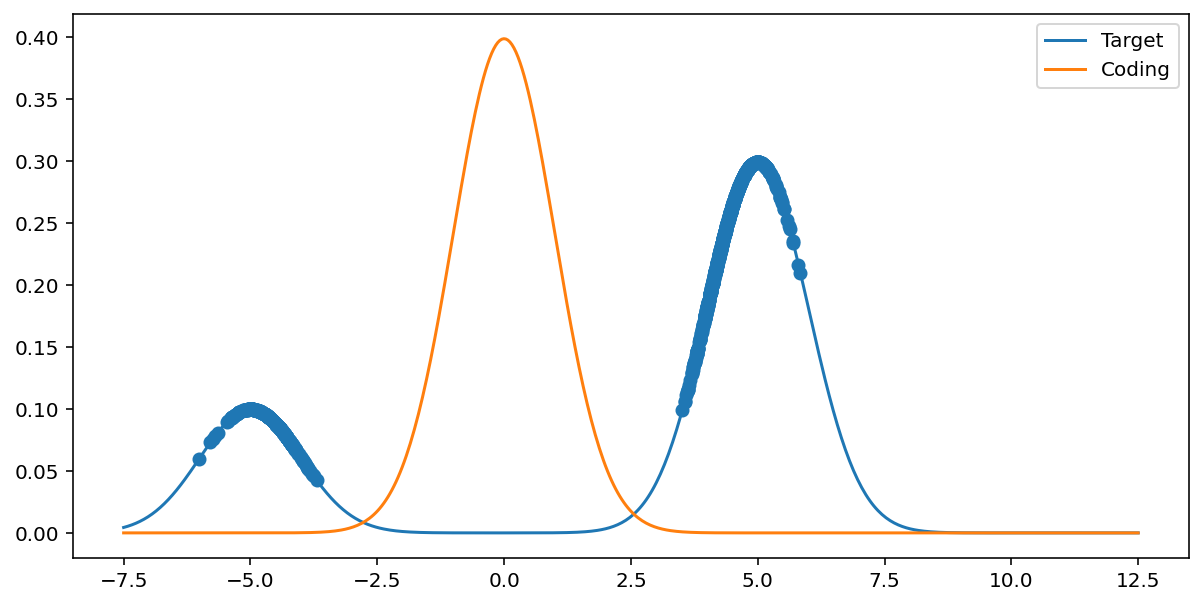

In [170]:
xs = torch.linspace(q_loc - 10, q_loc + 10, 500).reshape(-1, 1)

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(xs, torch.exp(q.log_prob(xs)), label='Target')
ax.plot(xs, torch.exp(p.log_prob(xs)), label='Coding')
ax.scatter(greedy_samples, torch.exp(q.log_prob(torch.tensor(greedy_samples).reshape(-1, 1))))

ax.legend()

plt.show()

/scratch/km817/miniconda3/envs/Torch/lib/python3.8/site-packages/numpy/ma/core.py:2825: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  _data = np.array(data, dtype=dtype, copy=copy,
/scratch/km817/miniconda3/envs/Torch/lib/python3.8/site-packages/numpy/ma/core.py:2825: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


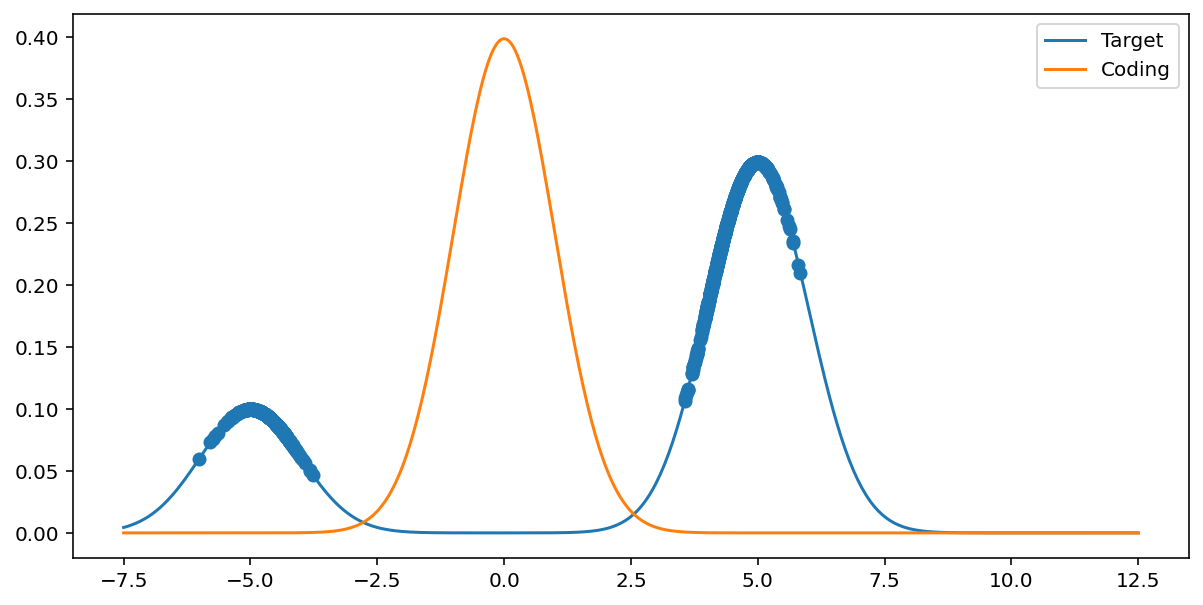

In [171]:
xs = torch.linspace(q_loc - 10, q_loc + 10, 500).reshape(-1, 1)

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(xs, torch.exp(q.log_prob(xs)), label='Target')
ax.plot(xs, torch.exp(p.log_prob(xs)), label='Coding')
ax.scatter(bw_5_samples, torch.exp(q.log_prob(torch.tensor(bw_5_samples).reshape(-1, 1))))

ax.legend()

plt.show()

/scratch/km817/miniconda3/envs/Torch/lib/python3.8/site-packages/numpy/ma/core.py:2825: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  _data = np.array(data, dtype=dtype, copy=copy,
/scratch/km817/miniconda3/envs/Torch/lib/python3.8/site-packages/numpy/ma/core.py:2825: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


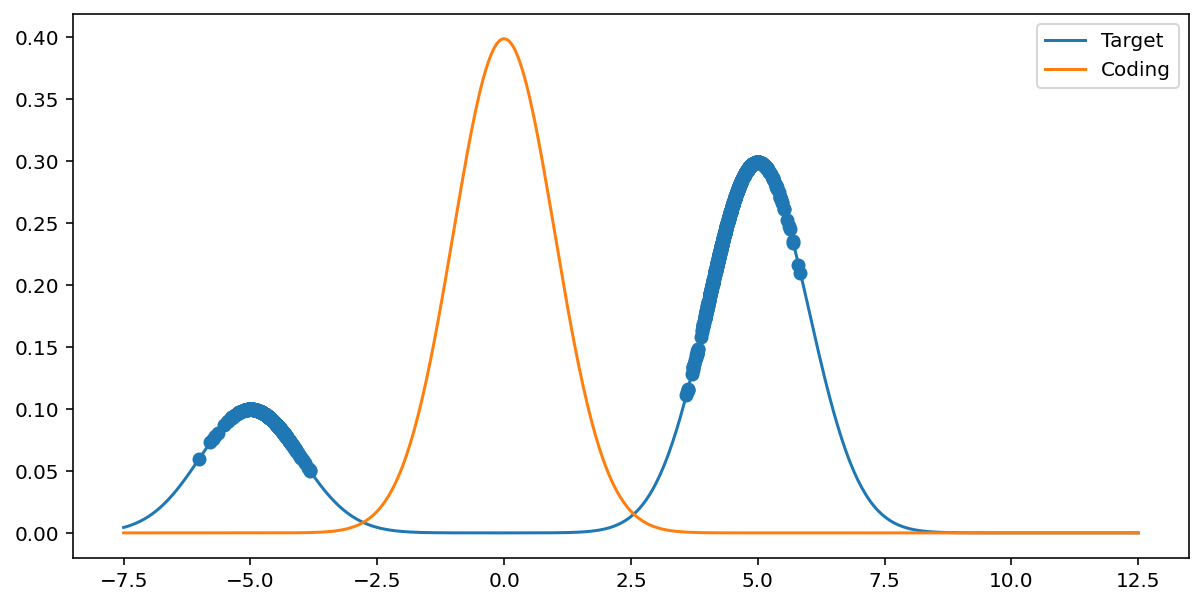

In [172]:
xs = torch.linspace(q_loc - 10, q_loc + 10, 500).reshape(-1, 1)

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(xs, torch.exp(q.log_prob(xs)), label='Target')
ax.plot(xs, torch.exp(p.log_prob(xs)), label='Coding')
ax.scatter(bw_20_samples, torch.exp(q.log_prob(torch.tensor(bw_20_samples).reshape(-1, 1))))

ax.legend()

plt.show()

/scratch/km817/miniconda3/envs/Torch/lib/python3.8/site-packages/numpy/ma/core.py:2825: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  _data = np.array(data, dtype=dtype, copy=copy,
/scratch/km817/miniconda3/envs/Torch/lib/python3.8/site-packages/numpy/ma/core.py:2825: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,
/scrat

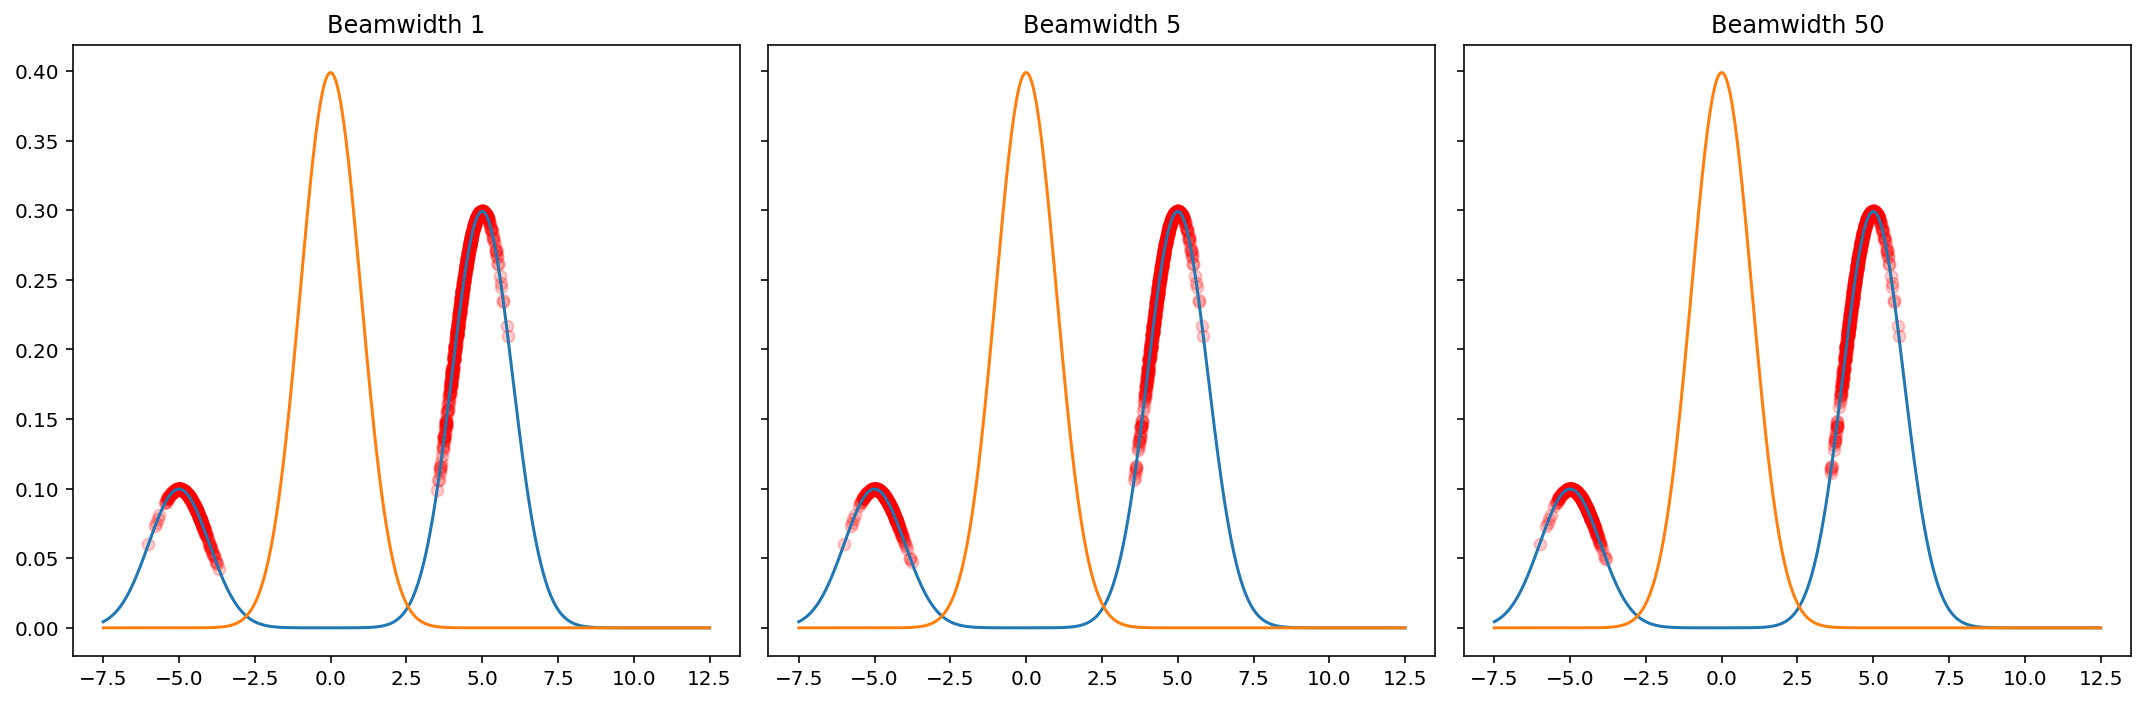

In [173]:
xs = torch.linspace(q_loc - 10, q_loc + 10, 500).reshape(-1, 1)

fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(15,5), sharex=True, sharey=True)

ax1.plot(xs, torch.exp(q.log_prob(xs)))
ax1.plot(xs, torch.exp(p.log_prob(xs)))
ax1.scatter(greedy_samples, torch.exp(q.log_prob(torch.tensor(greedy_samples).reshape(-1, 1))), color='r', alpha=0.2)
ax1.set_title('Beamwidth 1')

ax2.plot(xs, torch.exp(q.log_prob(xs)))
ax2.plot(xs, torch.exp(p.log_prob(xs)))
ax2.scatter(bw_5_samples, torch.exp(q.log_prob(torch.tensor(bw_5_samples).reshape(-1, 1))), color='r', alpha=0.2)
ax2.set_title('Beamwidth 5')

ax3.plot(xs, torch.exp(q.log_prob(xs)))
ax3.plot(xs, torch.exp(p.log_prob(xs)))
ax3.scatter(bw_50_samples, torch.exp(q.log_prob(torch.tensor(bw_50_samples).reshape(-1, 1))), color='r', alpha=0.2)
ax3.set_title('Beamwidth 50')
fig.tight_layout()